In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

  # Mount the Google Drive at mount
  mount='/content/drive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/ML-for-IC-Die-Images"

  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)

  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
  !pwd

  # !pip install -r requirements.txt
  # !sudo apt-get autoremove


  from IPython.display import JSON
  from google.colab import output
  from subprocess import getoutput

  # @title jQuery Terminal's [Features](https://terminal.jcubic.pl/)

  def shell(command):
    if command.startswith('cd'):
      path = command.strip().split(maxsplit=1)[1]
      os.chdir(path)
      return JSON([''])
    return JSON([getoutput(command)])
  output.register_callback('shell', shell)

In [2]:
if IN_COLAB:
    !pip install cupy-cuda112 tensorflow-addons

In [3]:
# Check the CUDA version
!nvcc --version

# Install the matching CuPy version (replace with the correct version based on CUDA output)
!pip install cupy-cuda11x

# %%
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import more_itertools
import sys
import cv2
import os
import time
from matplotlib import style
#style.use('classic')
from numpy import genfromtxt, asarray, savez_compressed, load
from sklearn.model_selection import train_test_split
import skimage
import PIL
from PIL import Image
from io import StringIO
# import memory_profiler
import numpy as np
import cupy
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import time
#style.use('classic')
from joblib import Parallel, delayed
from numpy import genfromtxt
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from scipy.signal import resample
from io import StringIO
import os
import shutil
#plt.style.use('ggplot')
#matplotlib.use( 'tkagg' )
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pylab as pl
import seaborn as sns
sns.set_style("ticks",{'axes.grid' : True})
from pathlib import Path
from collections.abc import Iterable
import math


import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv3D,Activation,Conv2D,Cropping2D, ConvLSTM2D, MaxPooling2D, MaxPooling3D, BatchNormalization, Flatten, Input, Dense, GRU, Embedding, LSTM, SimpleRNN, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical, Sequence, normalize
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from tensorflow.python.ops import math_ops, control_flow_ops
from tensorflow.python.framework import constant_op


if IN_COLAB:
  from google.colab import drive
  from tensorflow.keras.optimizers.legacy import RMSprop,Adam,SGD,Adadelta,Adagrad,Adamax
  from tqdm.notebook import tqdm_notebook
else:
  from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adadelta,Adagrad,Adamax
  from tqdm.autonotebook import tqdm


from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\akone\AppData\Roaming\Python\Python310\site-packages\cupy\_environment.py:487: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda112, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

In [4]:
from tensorflow.python.platform import build_info as tf_build_info
import tensorflow.python.platform.build_info as build
from tensorflow.compat.v1.keras.backend import set_session

try:
  # tf.debugging.experimental.enable_dump_debug_info('.', tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)
  # tf.debugging.set_log_device_placement(True)
  from tensorflow.python.client import device_lib

  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

  config = tf.compat.v1.ConfigProto()
  config.gpu_options.allow_growth = True
  config.gpu_options.per_process_gpu_memory_fraction = 0.1
  try:
    tf.compat.v1.InteractiveSession.close()
  except Exception as error:
    print("Error trying to delete session")
    print(error)
  sess = tf.compat.v1.InteractiveSession(config=config)
  set_session(sess)
  print(device_lib.list_local_devices())
  gpus = tf.config.experimental.list_physical_devices('GPU')
  for gpu in gpus:
    try:

      tf.config.experimental.set_memory_growth(gpu, True)
      # Restrict TensorFlow to only use the first GPU
      tf.config.set_visible_devices(gpus[0], 'GPU')
      logical_gpus = tf.config.list_logical_devices('GPU')
      print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
      # Visible devices must be set before GPUs have been initialized
      print(e)

except Exception as error:
    print("Error trying to configure computing device.")
    print(error)

print("TensorFlow verison: ",tf.__version__)
print("CUDA verison: ", build.build_info['cuda_version'])
print("CUDNN verison: ", build.build_info['cudnn_version'])



Found GPU at: /device:GPU:0
Error trying to delete session
InteractiveSession.close() missing 1 required positional argument: 'self'
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15118277635300869398
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4841275392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 980069557336232512
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]
1 Physical GPUs, 1 Logical GPU
TensorFlow verison:  2.10.1
CUDA verison:  64_112
CUDNN verison:  64_8


### Set Tensorflow-GPU precision
Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory.

In [5]:
# tf.keras.backend.floatx()
# tf.keras.backend.set_floatx('float16')
# tf.keras.backend.set_floatx('float32')
# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)
tf.keras.backend.floatx()

'float32'

In [6]:
# Change as you wish
if IN_COLAB:
  DATA_FOLDER = './data'
  TRAIN_FOLDER = './data/Train'
  VALIDATION_FOLDER = './data/Validation'
  IMAGE_INPUT_FOLDER = './data/Image_Input'
  IMAGE_OUTPUT_FOLDER = './data/Image_Output'
else:
  DATA_FOLDER = './../data'
  TRAIN_FOLDER = './../data/Train'
  VALIDATION_FOLDER = './../data/Validation'
  IMAGE_INPUT_FOLDER = './../data/Image_Input'
  IMAGE_OUTPUT_FOLDER = './../data/Image_Output'


In [7]:
# Set the paths to your annotated image folders
input_image_path = os.path.join(IMAGE_INPUT_FOLDER)
output_image_path = os.path.join(IMAGE_OUTPUT_FOLDER)


In [8]:
# Get the list of image and label file paths
input_filenames = sorted(glob.glob(os.path.join(input_image_path,'*.jpg')))[:]
output_filenames = sorted(glob.glob(os.path.join(output_image_path,'*.jpg')))[:]

len(input_filenames), len(output_filenames)

(61, 61)

In [9]:
for idx, inp_outp in enumerate(zip(input_filenames[:], output_filenames[:])):
  print(idx, inp_outp)

0 ('./../data/Image_Input\\100.jpg', './../data/Image_Output\\100.jpg')
1 ('./../data/Image_Input\\101.jpg', './../data/Image_Output\\101.jpg')
2 ('./../data/Image_Input\\102.jpg', './../data/Image_Output\\102.jpg')
3 ('./../data/Image_Input\\104.jpg', './../data/Image_Output\\104.jpg')
4 ('./../data/Image_Input\\107.jpg', './../data/Image_Output\\107.jpg')
5 ('./../data/Image_Input\\108.jpg', './../data/Image_Output\\108.jpg')
6 ('./../data/Image_Input\\109.jpg', './../data/Image_Output\\109.jpg')
7 ('./../data/Image_Input\\110.jpg', './../data/Image_Output\\110.jpg')
8 ('./../data/Image_Input\\111.jpg', './../data/Image_Output\\111.jpg')
9 ('./../data/Image_Input\\113.jpg', './../data/Image_Output\\113.jpg')
10 ('./../data/Image_Input\\114.jpg', './../data/Image_Output\\114.jpg')
11 ('./../data/Image_Input\\116.jpg', './../data/Image_Output\\116.jpg')
12 ('./../data/Image_Input\\117.jpg', './../data/Image_Output\\117.jpg')
13 ('./../data/Image_Input\\119.jpg', './../data/Image_Output

In [10]:
if len(input_filenames[:])==len(output_filenames[:]):
  print('Number of files in Input and Output folders are equal')
else:
  min_file_length = min([len(input_filenames[:]),len(output_filenames[:])])
  print(f'Uneven number images in Input and Output folders! \nSelecting minimum possible number of images: {min_file_length}')

Number of files in Input and Output folders are equal


In [11]:
min_file_length=-1
if IN_COLAB:
  check_ims = [in_name.split('/')[3]==out_name.split('/')[3] for in_name,out_name in zip(input_filenames[:min_file_length], output_filenames[:min_file_length])]
else:
  check_ims = [in_name.split('\\')[1]==out_name.split('\\')[1] for in_name,out_name in zip(input_filenames[:min_file_length], output_filenames[:min_file_length])]
any(not x for x in check_ims) #Check if at least one image names is not corresponding

False

In [12]:
test_size = 0.05  #Specify test percentage

# Split the image and label file paths into training and validation sets
train_image_paths, validation_image_paths, train_label_paths, validation_label_paths = train_test_split(input_filenames[:], output_filenames[:], test_size=test_size, shuffle=True)

# Create the training and validation folders
train_folder_path = os.path.join(TRAIN_FOLDER)
validation_folder_path = os.path.join(VALIDATION_FOLDER)

os.makedirs(os.path.join(train_folder_path, 'Input_Image'), exist_ok=True)
os.makedirs(os.path.join(train_folder_path, 'Output_Image'), exist_ok=True)
os.makedirs(os.path.join(validation_folder_path, 'Input_Image'), exist_ok=True)
os.makedirs(os.path.join(validation_folder_path, 'Output_Image'), exist_ok=True)

'''
# Copy the training images and labels to the training folder
for image_path, label_path in zip(train_image_paths, train_label_paths):
    image_name = os.path.basename(image_path)
    label_name = os.path.basename(label_path)
    shutil.copy(image_path, os.path.join(train_folder_path, 'Input_Image', image_name))
    shutil.copy(label_path, os.path.join(train_folder_path, 'Output_Image',label_name))

# Copy the validation images and labels to the validation folder
for image_path, label_path in zip(validation_image_paths, validation_label_paths):
    image_name = os.path.basename(image_path)
    label_name = os.path.basename(label_path)
    shutil.copy(image_path, os.path.join(validation_folder_path, 'Input_Image', image_name))
    shutil.copy(label_path, os.path.join(validation_folder_path, 'Output_Image', label_name))
'''

"\n# Copy the training images and labels to the training folder\nfor image_path, label_path in zip(train_image_paths, train_label_paths):\n    image_name = os.path.basename(image_path)\n    label_name = os.path.basename(label_path)\n    shutil.copy(image_path, os.path.join(train_folder_path, 'Input_Image', image_name))\n    shutil.copy(label_path, os.path.join(train_folder_path, 'Output_Image',label_name))\n\n# Copy the validation images and labels to the validation folder\nfor image_path, label_path in zip(validation_image_paths, validation_label_paths):\n    image_name = os.path.basename(image_path)\n    label_name = os.path.basename(label_path)\n    shutil.copy(image_path, os.path.join(validation_folder_path, 'Input_Image', image_name))\n    shutil.copy(label_path, os.path.join(validation_folder_path, 'Output_Image', label_name))\n"

In [13]:
class CustomDataGenerator(Sequence):
    def __init__(self, input_paths, output_paths, batch_size, input_shape, num_classes=5, plot=False):
        self.input_paths = input_paths
        self.output_paths = output_paths
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.plot = plot
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.input_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        input_batch_paths = self.input_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        output_batch_paths = self.output_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        input_images = cupy.asnumpy(list(map(self.image_dataloader, input_batch_paths))).astype(np.float32)
        output_images = cupy.asnumpy(list(map(self.image_dataloader, output_batch_paths))).astype(np.float32)
        segmentation_mask = cupy.asnumpy(list(map(self.mask_generator, [output_image - input_image for input_image, output_image in zip(input_images,output_images)]))).astype(np.float32)
        return input_images, segmentation_mask


    def image_dataloader(self, image_path, GRAY=True):
        # Load the input image
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.reshape(image.shape[0],image.shape[1],image.shape[2])
        # Resize the image with padding
        image = cv2.resize(image, self.input_shape, interpolation=cv2.INTER_AREA)
        # image = resize_with_padding(image, self.input_shape)
        # Add an alpha channel to the input image
        # image = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
        if self.plot:
            plt.figure()
            plt.imshow(image)
            plt.title(f'Path: {image_path}')
            plt.show()
        return image/255.

    def mask_generator(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = skimage.filters.gaussian(image, sigma=1.0)
        t = skimage.filters.threshold_otsu(image)
        image = image > t
        return image.reshape(image.shape[0],image.shape[1],1)


In [14]:
height, width, channels = 512, 512, 3   # Choose maximum possible image size in order not to compromise quality
batch_size = 3

In [15]:
train_generator = CustomDataGenerator(train_image_paths, train_label_paths, batch_size,
                                      input_shape=(height, width), num_classes=5, plot=False)

validation_generator = CustomDataGenerator(validation_image_paths, validation_label_paths, batch_size,
                                           input_shape=(height, width), num_classes=5, plot=False)

input_train_batch, output_train_batch = next(iter(train_generator))

print('x_train shape: ', input_train_batch.shape, 'x_train dtype:', input_train_batch.dtype)
print('y_train shape: ', output_train_batch.shape, 'y_train dtype:', output_train_batch.dtype)
# print('y_train shape: ', output_train_batch[0].shape, 'y_train dtype:', output_train_batch[0].dtype)
# print('y_train shape: ', output_train_batch[1].shape, 'y_train dtype:', output_train_batch[1].dtype)

input_validation_batch, output_validation_batch=next(iter(validation_generator))

print('x_val shape: ', input_validation_batch.shape, 'x_val dtype:', input_validation_batch.dtype)
print('y_val shape: ', output_validation_batch.shape, 'y_val dtype:', output_validation_batch.dtype)
# print('y_val shape: ', output_validation_batch[0].shape, 'y_val dtype:', output_validation_batch[0].dtype)
# print('y_val shape: ', output_validation_batch[1].shape, 'y_val dtype:', output_validation_batch[1].dtype)

x_train shape:  (3, 512, 512, 3) x_train dtype: float32
y_train shape:  (3, 512, 512, 1) y_train dtype: float32
x_val shape:  (3, 512, 512, 3) x_val dtype: float32
y_val shape:  (3, 512, 512, 1) y_val dtype: float32


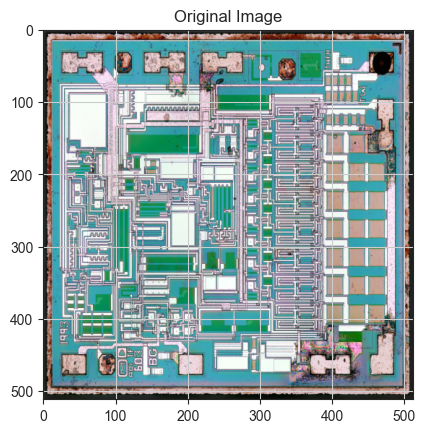

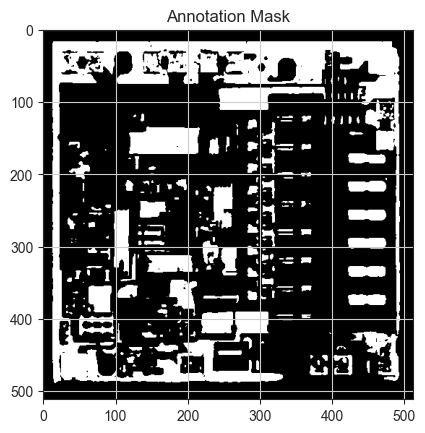

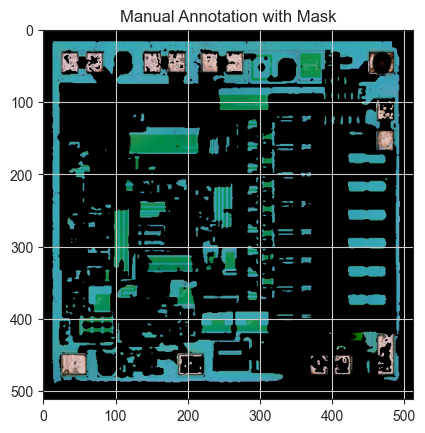

In [16]:
plt.imshow(input_validation_batch[1], cmap=('jet'))
plt.title('Original Image')
plt.show()
plt.imshow(output_validation_batch[1], cmap='gray')
plt.title('Annotation Mask')
plt.show()
masked_image = input_validation_batch[1].copy()
masked_image[~output_validation_batch[1].astype('bool').repeat(3, axis=-1)] = 0
plt.imshow(masked_image, cmap=('jet'))
plt.title('Manual Annotation with Mask')
plt.show()

In [17]:
# with tf.device('/device:GPU:0'):
    # tf.data.experimental.enable_debug_mode()
    # tf.config.run_functions_eagerly(True)
# @tf.function(experimental_relax_shapes=True, reduce_retracing=True)
# with tf.device('/device:GPU:0'):
    # tf.data.experimental.enable_debug_mode()
    # tf.config.run_functions_eagerly(True)
# @tf.function(experimental_relax_shapes=True, reduce_retracing=True)


class CustomLoss(tf.keras.losses.Loss):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        pass

    def call(self, y_true, y_pred):
        # ...
      def __init__(self, **kwargs):
        super().__init__(**kwargs)
        pass

    # @tf.autograph.experimental.do_not_convert   # breakpoint now recognized with this decorator
    def call(self, y_true, y_pred):

        # Define the Dice Loss
        return self.combined_loss(y_true, y_pred)

    def dice_loss(self, y_true, y_pred, smooth=1e-6):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        intersection = tf.reduce_sum(y_true * y_pred)
        return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

    def mean_squared_error_loss(self, y_true, y_pred):
        y_true_signed_distance = tf.cast(y_true, tf.float32)
        y_pred_signed_distance = tf.cast(y_pred, tf.float32)
        return tf.reduce_mean((y_true_signed_distance - y_pred_signed_distance) ** 2)

    def smearing_penalty(self, y_pred, kernel_size=3):
        kernel = tf.ones((kernel_size, kernel_size, 1, 1), dtype=tf.float32) / (kernel_size ** 2)
        smeared_mask = tf.nn.conv2d(y_pred, kernel, strides=[1, 1, 1, 1], padding="SAME")
        return tf.reduce_mean(tf.abs(smeared_mask - y_pred))

    def combined_loss(self, y_true, y_pred, alpha=0.5, beta=0.5, gamma=0.5):
        dice = self.dice_loss(y_true, y_pred)
        wasserstein = self.mean_squared_error_loss(y_true, y_pred)
        smearing = self.smearing_penalty(y_pred)
        return alpha * dice + beta * wasserstein + gamma * smearing


class IoU(tf.keras.metrics.Metric):
    def __init__(self, name="IoU", **kwargs):
        super(IoU, self).__init__(name=name, **kwargs)
        self.iou = None

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.iou = self.iou_coef(y_true, y_pred)
        return
    
    def result(self):
        return self.iou

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.iou = None
        return
    
    def iou_coef(self, y_true, y_pred,smooth=1):
        intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
        union = tf.reduce_sum(y_true,[1,2,3])+tf.reduce_sum(y_pred,[1,2,3])-intersection
        iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
        return iou



 
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super(CustomLoss, self).__init__()

    # @tf.autograph.experimental.do_not_convert   # breakpoint now recognized with this decorator
    def call(self, y_true, y_pred):

        # Define the Dice Loss
        return self.combined_loss(y_true, y_pred)

    def dice_loss(self, y_true, y_pred, smooth=1e-6):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])
        intersection = tf.reduce_sum(y_true * y_pred)
        return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

    def mean_squared_error_loss(self, y_true, y_pred):
        y_true_signed_distance = tf.cast(y_true, tf.float32)
        y_pred_signed_distance = tf.cast(y_pred, tf.float32)
        return tf.reduce_mean((y_true_signed_distance - y_pred_signed_distance) ** 2)

    def smearing_penalty(self, y_pred, kernel_size=3):
        kernel = tf.ones((kernel_size, kernel_size, 1, 1), dtype=tf.float32) / (kernel_size ** 2)
        smeared_mask = tf.nn.conv2d(y_pred, kernel, strides=[1, 1, 1, 1], padding="SAME")
        return tf.reduce_mean(tf.abs(smeared_mask - y_pred))

    def combined_loss(self, y_true, y_pred, alpha=0.5, beta=0.5, gamma=0.5):
        dice = self.dice_loss(y_true, y_pred)
        wasserstein = self.mean_squared_error_loss(y_true, y_pred)
        smearing = self.smearing_penalty(y_pred)
        return alpha * dice + beta * wasserstein + gamma * smearing

 


# Load the TensorBoard notebook extension
# %load_ext tensorboard
%reload_ext tensorboard

%tensorboard --logdir './data/model/TensorBoard'

In [18]:
def build_annotator_model(input_shape, output_channels, dropout_rate=0.0):
    """
    Builds a TensorFlow model that takes original images as input and produces annotated images as output.

    Args:
        input_shape: The shape of the input image (e.g. (256, 256, 3) for a 256x256 RGB image).
        output_channels: The number of output channels (i.e. the number of annotation colors).

    Returns:
        The TensorFlow model.
    """
    # Define the input layer
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='gelu')(inputs)
    conv1 = tf.keras.layers.Dropout(dropout_rate)(conv1)
    # conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='gelu')(conv1)
    bn1 = tf.keras.layers.BatchNormalization(name='BN1')(conv1)

    conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='gelu')(bn1)
    conv2 = tf.keras.layers.Dropout(dropout_rate)(conv2)
    # conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='gelu')(conv2)
    bn2 = tf.keras.layers.BatchNormalization(name='BN2')(conv2)

    conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='gelu')(bn2)
    conv3 = tf.keras.layers.Dropout(dropout_rate)(conv3)
    # conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='gelu')(conv3)
    bn3 = tf.keras.layers.BatchNormalization(name='BN3')(conv3)

    conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='gelu')(bn3)
    conv4 = tf.keras.layers.Dropout(dropout_rate)(conv4)
    # conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='same', activation='gelu')(conv4)
    bn4 = tf.keras.layers.BatchNormalization(name='BN4')(conv4)

    conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=2, padding='same', activation='gelu')(bn4)
    conv5 = tf.keras.layers.Dropout(dropout_rate)(conv5)
    # conv5 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=2, padding='same', activation='gelu')(conv5)
    bn5 = tf.keras.layers.BatchNormalization(name='BN5')(conv5)


    # Decoder
    deconv1 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='gelu')(bn5)
    deconv1 = tf.keras.layers.Dropout(dropout_rate)(deconv1)
    #deconv1 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='gelu')(deconv1)
    bn6 = tf.keras.layers.BatchNormalization(name='BN6')(deconv1)

    skip1 = tf.keras.layers.concatenate([bn4, bn6])

    deconv2 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='gelu')(skip1)
    deconv2 = tf.keras.layers.Dropout(dropout_rate)(deconv2)
    # deconv2 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='gelu')(deconv2)
    bn7 = tf.keras.layers.BatchNormalization(name='BN7')(deconv2)

    skip2 = tf.keras.layers.concatenate([bn3, bn7])

    deconv3 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='gelu')(skip2)
    deconv3 = tf.keras.layers.Dropout(dropout_rate)(deconv3)
    # deconv3 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='gelu')(deconv3)
    bn8 = tf.keras.layers.BatchNormalization(name='BN8')(deconv3)

    skip3 = tf.keras.layers.concatenate([bn2, bn8])

    deconv4 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='gelu')(skip3)
    deconv4 = tf.keras.layers.Dropout(dropout_rate)(deconv4)
    # deconv4 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='gelu')(deconv4)

    bn9 = tf.keras.layers.BatchNormalization(name='BN9')(deconv4)
    skip4 = tf.keras.layers.concatenate([bn1, bn9])

    deconv5 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='gelu')(skip4)
    deconv5 = tf.keras.layers.Dropout(dropout_rate)(deconv5)
    # deconv5 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='gelu')(deconv5)
    bn10 = tf.keras.layers.BatchNormalization(name='BN10')(deconv5)

    segmentation_mask = tf.keras.layers.Conv2DTranspose(filters=output_channels, kernel_size=3, strides=1, padding='same', activation='sigmoid')(bn10)

    # annotated_pred = tf.keras.layers.Multiply()([inputs, segmentation_mask])
    # annotated_pred = tf.keras.layers.Add()([inputs, segmentation_mask])
    # annotated_pred = tf.keras.layers.Multiply()([annotated_pred,(tf.ones_like(input_validation_batch[0].shape)*255.) ])
    # annotated_pred = tf.keras.layers.Activation('sigmoid')(annotated_pred)

    # outputs = tf.keras.layers.Flatten()(annotated_pred)
    # outputs = tf.keras.layers.Dense(input_shape[0], activation='softmax')(outputs)
    # outputs = tf.keras.layers.Reshape(target_shape=(input_shape[0],input_shape[1],channels))(outputs)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=segmentation_mask, name='Annotation_model')

    return model

try:
  del model
except:
  pass

# Define the input and output shapes
input_shape = (height, width, channels)
output_channels = 1

# if model:  del model
# Build the model
model = build_annotator_model(input_shape, output_channels)

# Create Optimizer.
# Define the parameters for the schedule
initial_learning_rate = 1e-2
decay_steps = 1200
first_decay_steps = 1200

# Create the schedule
optimizer = Adam(learning_rate=initial_learning_rate, amsgrad=True)
moving_avg_Adam = tfa.optimizers.MovingAverage(optimizer)
stocastic_avg_Adam = tfa.optimizers.SWA(optimizer)

# Compile the model with an appropriate loss function and optimizer
# model.compile(loss=PixelWiseCrossEntropy(), optimizer=optimizer, metrics=['acc'], run_eagerly=True)
model.compile(loss=CustomLoss(), optimizer=stocastic_avg_Adam, metrics=['mse','acc', IoU()], run_eagerly=True)
model.build((None, *input_shape))

with tf.device('/device:GPU:0'):
  # _ = model.predict(validation_generator, steps=1, verbose=1)
  # _ = model.evaluate(train_generator, verbose=1)
  # _ = model.fit(train_generator, epochs=1, verbose=1)
  pass

model.summary()


Model: "Annotation_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv2d[0][0]']                 
                                )                                                  

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [19]:
save_format = 'h5'
with tf.device('/device:GPU:0'):
    try:
        # model = load_model(os.path.join(DATA_FOLDER, f'model/Annotation_model_RGB.{save_format}'), {"CustomLoss":CustomLoss(),"IoU":IoU()}, compile=True)
        model.load_weights(os.path.join(DATA_FOLDER, f'model/Annotation_model_RGB.{save_format}'))
        print("Checkpoint Loaded")
    except Exception as error:
        print("Error trying to load checkpoint.")
        print(error)

Checkpoint Loaded


## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [20]:
train_steps = steps_per_epoch = len(train_image_paths)//batch_size
test_steps = validation_steps =  len(validation_image_paths)//batch_size
test_generator = validation_generator

with tf.device('/device:GPU:0'):
    model.evaluate(train_generator, steps=train_steps)
    model.evaluate(validation_generator, steps=validation_steps)
    model.evaluate(test_generator, steps=test_steps)

1/1 [==============================] - 14s 14s/step - loss: 0.1892 - mse: 0.0744 - acc: 0.9136 - IoU: 0.5160


Predict on Test Set

1/1 [==============================] - 0s 132ms/step


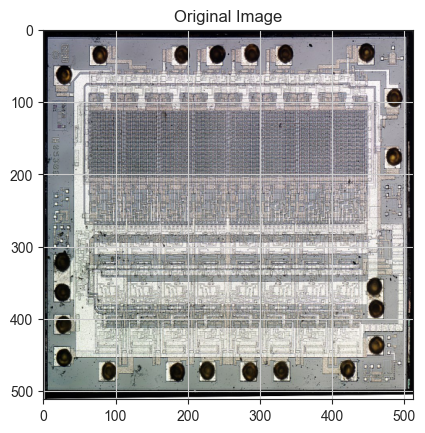

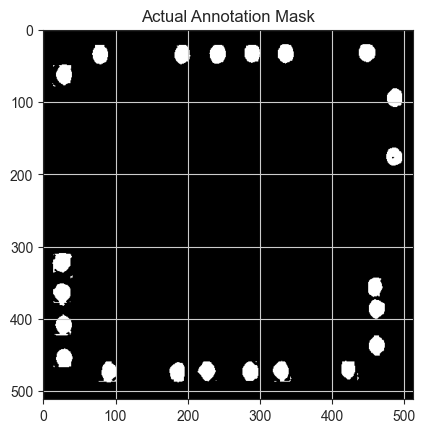

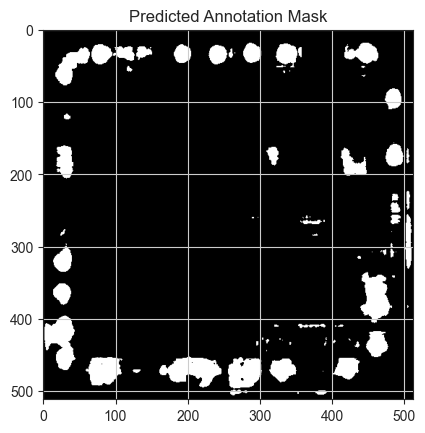

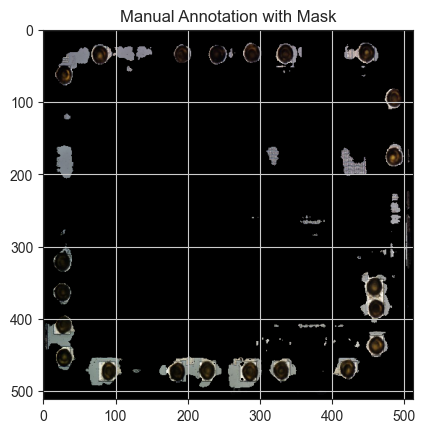

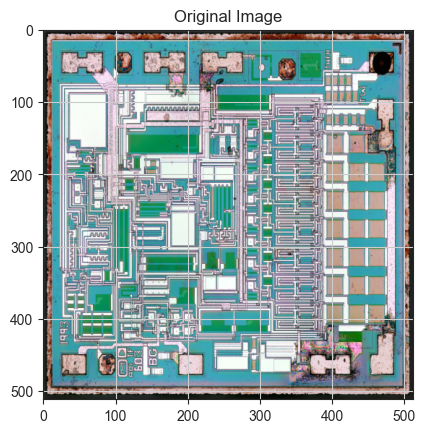

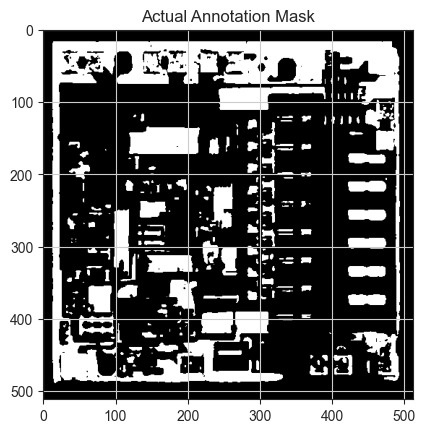

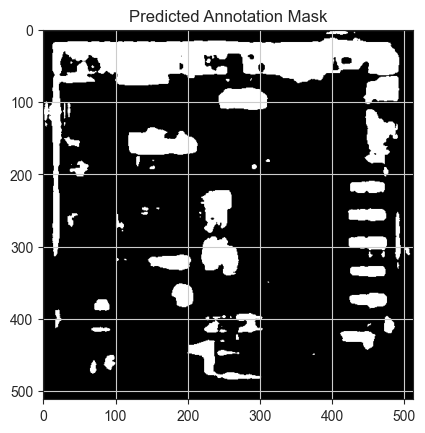

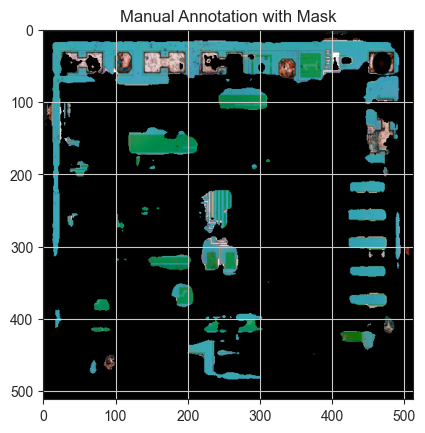

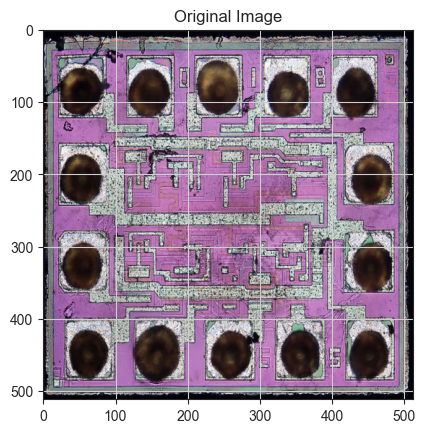

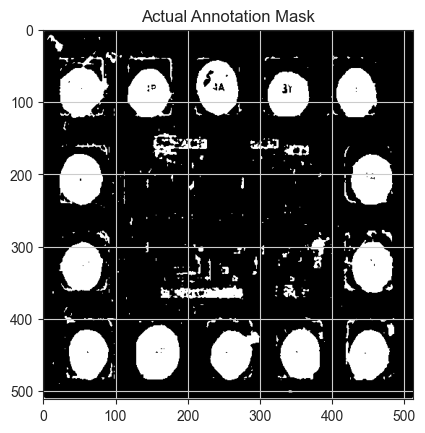

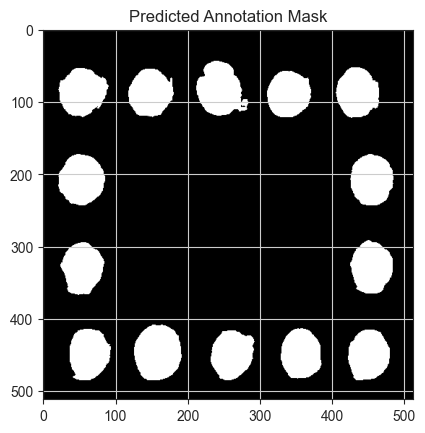

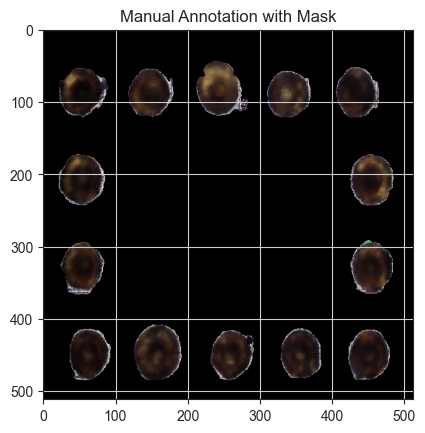

In [21]:
input_validation_batch, output_validation_batch=next(iter(validation_generator))
masks = (0.5*(1+tf.math.sign(model.predict(input_validation_batch)-0.5))).astype('bool')
for i in range(batch_size):
    plt.figure()
    plt.imshow(input_validation_batch[i], cmap='gray')
    plt.title('Original Image')
    plt.show()
    plt.figure()
    plt.imshow(output_validation_batch[i], cmap='gray')
    plt.title('Actual Annotation Mask')
    plt.show()
    plt.figure()
    plt.imshow(masks[i], cmap='gray')
    plt.title('Predicted Annotation Mask')
    plt.show()
    plt.figure()
    masked_image = input_validation_batch[i].copy()
    masked_image[~masks[i].numpy().repeat(3, axis=-1)] = 0
    plt.imshow(masked_image, cmap='gray')
    plt.title('Manual Annotation with Mask')
    plt.show()